# Dataset Mail

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/mail_data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5608,spam,You've been selected for a survey. Participate...
5609,spam,Get a free sample of our product. Order now: w...
5610,spam,Special offer for subscribers only! Redeem now...
5611,spam,Your insurance policy needs renewal. Click her...


## Re-train Model

In [3]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df['Category'] = df['Category'].str.lower()
df['Category'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5608,1,You've been selected for a survey. Participate...
5609,1,Get a free sample of our product. Order now: w...
5610,1,Special offer for subscribers only! Redeem now...
5611,1,Your insurance policy needs renewal. Click her...


In [5]:
tokenizer = AutoTokenizer.from_pretrained("nahiar/spam-detection-bert-v2")
model = AutoModelForSequenceClassification.from_pretrained("nahiar/spam-detection-bert-v2")

In [6]:
# Preprocessing - Tokenize the email messages
def tokenize_function(text):
    # Fungsi untuk men-tokenisasi teks email dan mengubahnya menjadi input untuk model
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

In [7]:
# Tokenizing email messages
texts = list(df['Message'])  # Mengambil semua teks dari kolom 'Message'
labels = list(df['Category'])  # Mengambil semua Categ (0 atau 1)
tokenized_texts = [tokenize_function(text) for text in texts]  # Tokenisasi semua teks

In [8]:
# Prepare input tensors for PyTorch
# Menggabungkan token input dan attention mask menjadi tensor yang siap digunakan untuk training
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(labels)

In [9]:
# Membagi dataset menjadi data training dan data validasi (80% training, 20% testing)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [10]:
# Membuat DataLoader untuk mini-batch training dan validation
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [11]:
# Training setup
from torch.optim import AdamW

# Optimizer digunakan untuk mengupdate parameter model selama training
optimizer = AdamW(model.parameters(), lr=2e-5)

In [12]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3080


In [13]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()

    total_loss = 0

    # Tambahkan tqdm untuk loop training
    train_loop = tqdm(train_dataloader, desc="Training", leave=False)

    for batch in train_loop:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Update progress bar dengan current loss
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    true_labels_list = []

    val_loop = tqdm(validation_dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            predictions_list.extend(predictions.tolist())
            true_labels_list.extend(batch_labels.tolist())

            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/3


Training:   0%|          | 0/281 [00:00<?, ?it/s]c:\Dev\ML_spam-detection\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Average training loss: 0.1169


Validation Accuracy: 98.13%

Epoch 2/3


Average training loss: 0.0370


Validation Accuracy: 97.60%

Epoch 3/3


Average training loss: 0.0159


Validation Accuracy: 95.10%


Confusion Matrix:
[[953  35]
 [ 20 115]]


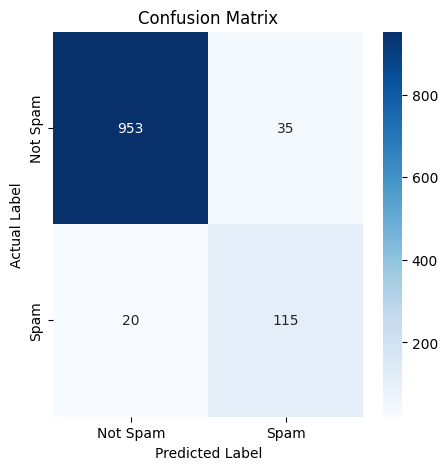

In [14]:
# Confusion Matrix & Evaluation Metrics
cm = confusion_matrix(true_labels_list, predictions_list)
print(f"Confusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Generate and print the classification report
classification_rep = classification_report(true_labels_list, predictions_list, target_names=['not spam', 'spam'])
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    not spam       0.98      0.96      0.97       988
        spam       0.77      0.85      0.81       135

    accuracy                           0.95      1123
   macro avg       0.87      0.91      0.89      1123
weighted avg       0.95      0.95      0.95      1123



In [16]:
# Save model

model.save_pretrained("../models/v3")
tokenizer.save_pretrained("../models/v3")

('../models/v3\\tokenizer_config.json',
 '../models/v3\\special_tokens_map.json',
 '../models/v3\\vocab.txt',
 '../models/v3\\added_tokens.json',
 '../models/v3\\tokenizer.json')

In [17]:
tokenizer = AutoTokenizer.from_pretrained("../models/v3")
model = AutoModelForSequenceClassification.from_pretrained("../models/v3")

In [18]:
# Define a function
def predict_spam(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = torch.argmax(probs, dim=1).item()
    label_map = {0: "HAM", 1: "SPAM"}
    return label_map[predicted_label]

In [19]:
input_text = '🌬 🔥 PSN 100 Deal 🔥 #EAFC26 #EAFC 100€ PSN für nur 80,64€ 💸19,36€ geschenkt 👉 https://t.co/ilhqQHizDy* 🔑Code: FORAUM8JUL Besten Preis wählen und mit SEPA zahlen #deal_bot #Guthaben #Rabatt #PSN #FIFA'
print(predict_spam(input_text, model, tokenizer))

SPAM


c:\Dev\ML_spam-detection\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [20]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'Senin, 21 Juli 2025, Samapta Polsek Ngaglik melaksanakan patroli stasioner balong jalan palagan donoharjo serta antisipasi gangguan Kamtibmas, Curat, Curas, Curan dan kejahatan jalanan di wilayah Ngaglik. https://t.co/TyIvxehCV9'
print(predict_spam(input_text, model, tokenizer))

HAM


In [21]:
input_text = 'lacak hp hilang by no hp / imei lacak penipu/scammer/tabrak lari/terror/revengeporn sadap / hack / pulihkan akun #zonauang #zonauang?'
print(predict_spam(input_text, model, tokenizer))

SPAM


In [22]:
input_text = 'Mari berkontribusi terhadap gerakan rakyat dengan membeli baju ini seharga Rp 160.000. Berikut format pemesanannya:  Nama: Alamat: Nomor WA: Ukuran:  Hubungi kami melalui WA 08977472296  *Harga di atas di luar ongkos kirim*'
print(predict_spam(input_text, model, tokenizer))

SPAM
